Questions:

What is distribution of volume spanned by single branch?
What is distribution of node spacing?
What is distribution of radii?
What is distribution of total nodes in a branch?
What is distribution of total nodes in a cell?

for each file

read line by line
extract coords
calc euclidean distance from prev point
keep track of min, max x/y/z
return span of x/y/z
calculate volume

In [12]:
import os

# get human trajectories
fnames = []
abs_paths = []
for root, dirs, fnames_ in os.walk("../data/03_human_branches_splitted/"):
    fnames.extend(fnames_)
    for f in fnames_:
        relpath = os.path.join(root, f)
        abs_path = os.path.abspath(relpath)
        abs_paths.append(abs_path)

if len(fnames) == 0:
    raise Exception("No SWC files found. Please run data generating scripts from data_processing directory")
print(len(fnames), "SWC files found")

61228 SWC files found


In [13]:
import numpy as np
# https://stackoverflow.com/a/15934081/4212158
# catch np.sqrt RunTimeWarning as exception
#np.seterr(all='raise')

dim_spans = []
node_distances = []
volumes = []
radii = []
n_nodes_per_branch = []
n_branches = 0
n_skipped = 0
fp_errors = 0

for fpath in abs_paths:  # for each branch
    x_coords = []
    y_coords = []
    z_coords = []
    radii_ = []
    n_nodes = 0
    
    input = open(fpath, "r")
    prev = None  # the previous node
    for line in input:  # for each node
        n_nodes += 1
        
        # note: if the parent node is -1, then the child_node_id is the true identity of the root node
        try:
            _, _, x_coord, y_coord, z_coord, radius, _ = line.split()
        except ValueError:
            raise Exception("node is malformed")
        # convert string to f loat
        x_coord, y_coord, z_coord, radius = [np.float(x) for x in [x_coord, y_coord, z_coord, radius]]
            
        if prev is not None:
            try:
                distance = np.sqrt((x_coord-prev["x"])**2 +
                              (y_coord-prev["y"])**2 +
                              (z_coord-prev["z"])**2)
                
                node_distances.append(distance)
            except FloatingPointError:
                #print(x_coord, prev["x"], y_coord, prev["y"], z_coord, prev["z"])
                fp_errors += 1
                print("x", x_coord-prev["x"]**2, type(x_coord))
                print("y", y_coord-prev["y"]**2)
                print("z", z_coord-prev["z"]**2, type(z_coord))
                print(distance)
                
            x_coords.append(x_coord)
            y_coords.append(y_coord)
            z_coords.append(z_coord)
            radii_.append(radius)
            
            
        prev = {"x": x_coord, "y": y_coord, "z": z_coord}  # replace prev_node
        
    x_span = np.max(x_coords) - np.min(x_coords)
    y_span = np.max(y_coords) - np.min(y_coords)
    z_span = np.max(z_coords) - np.min(z_coords)
    volume = x_span * y_span * z_span
    
    volumes.append(volume)
    radii.extend(radii_)
    dim_spans.extend([x_span, y_span, z_span])
    n_nodes_per_branch.append(n_nodes)
    
    
    n_branches += 1
    
    #print("branch {} completed".format(n_branches))
            
    input.close()

In [14]:
print(n_skipped)
print(fp_errors)

0
0


False
False


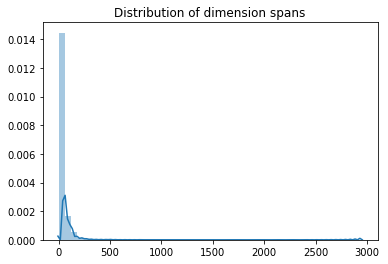

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

print(np.any(np.isnan(dim_spans)))
print(np.any(np.isinf(dim_spans)))
sns.distplot(dim_spans)
plt.title("Distribution of dimension spans")
plt.show()

/home/shit/bin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/home/shit/bin/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/shit/bin/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Radii span:  1.0 1.0


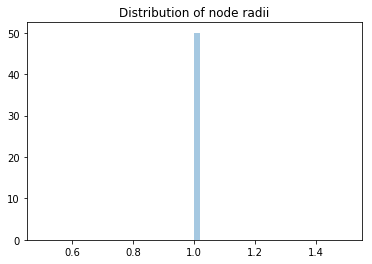

In [18]:
sns.distplot(radii)
plt.title("Distribution of node radii")
print("Radii span: ", np.min(radii), np.max(radii))

All radii are exactly 1.0.

Text(0.5,1,'Distribution of branch volumes')

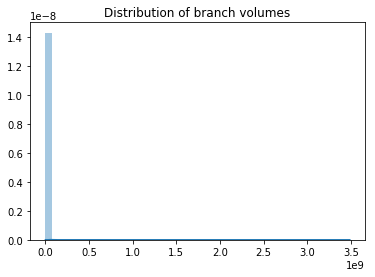

In [19]:
sns.distplot(volumes)
plt.title("Distribution of branch volumes")

# Internode distances

Text(0.5,1,'Distribution of inter-node distances')

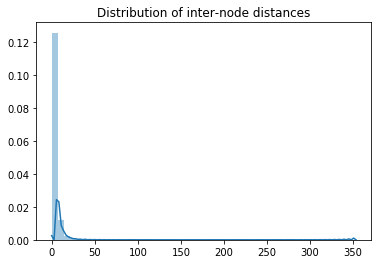

In [20]:
sns.distplot(node_distances)
plt.title("Distribution of inter-node distances")


Text(0.5,1,'distribution of internode distance, with long tail chopped off')

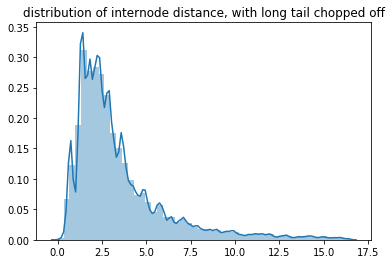

In [65]:
# https://stackoverflow.com/a/22546769/4212158
n=80
np.partition(node_distances, n)[n]
n2=1200000  # throwing out the long tail
points = np.partition(node_distances, n2)[:n2]
sns.distplot(points)
plt.title("distribution of internode distance, with long tail chopped off")

There are 80 nodes which were placed right on top of each other. The node distances have a very large tail, but the vast majority of distances are between 1 and 4.

Text(0.5,1,'Distribution of # nodes per branch')

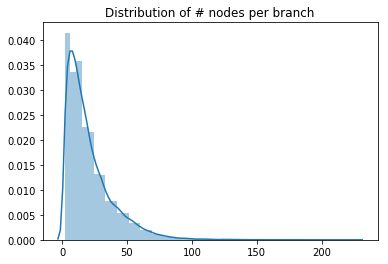

In [21]:
sns.distplot(n_nodes_per_branch)
plt.title("Distribution of # nodes per branch")

Most branches have less than 75 nodes.